# 18.335 Problem Set 2 Solutions

This notebook accompanies the second problem set posted on the [18.335 web page](https://github.com/mitmath/18335).

First, let's bring in the packages that will be useful throughout.

In [1]:
using LinearAlgebra
using BandedMatrices
using Plots

# Problem 1: Stability and conditioning for linear systems

## Part (a) - Trefethen and Bau, Exercise 18.1.

### Part (i)

The pseudoinverse of $A$ is $A^+ = (A^TA)^{-1}A^T$ and the orthogonal projector onto the column space of $A$ is $P=AA^+$. Using the $2\times 2$ inversion formula, we calculate directly that
$$
A^TA = \begin{pmatrix}
3 & 3.0002 \\
3.0002 & 3.00040002
\end{pmatrix}, \qquad\text{and}\qquad
(A^TA)^{-1} = \frac{1}{2\times 10^{-8}}
\begin{pmatrix}
3.00040002 & - 3.0002 \\
-3.0002 & 3
\end{pmatrix}.
$$
Multiplying $(A^TA)^{-1}$ first by $A^T$ on the right, we find that
$$
A^+ = \frac{1}{2\times 10^{-8}}\begin{pmatrix}
0.00020002 & -0.0001 & -0.0001 \\
-0.0002 & 0.0001 & 0.0001 \\
\end{pmatrix}
=
\begin{pmatrix}
10001 & -5000 & -5000 \\
-10000 & 5000 & 5000 \\
\end{pmatrix}.
$$
Finally, multiplying $A^+$ by $A$ on the left, we arrive at

$$
P =
\begin{pmatrix}
1 & 1 \\
1 & 1.0001 \\
1 & 1.0001
\end{pmatrix}
\begin{pmatrix}
10001 & -5000 & -5000 \\
-10000 & 5000 & 5000 \\
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & 0\\
0 & 1/2 & 1/2 \\
0 & 1/2 & 1/2
\end{pmatrix}.
$$

### Part (ii)

The exact solutions to the least-squares problem are $x=A^+b$ and $y=Pb$ or, equivalently, $y=AA^+b$. We calculate that 
$$
x =
\begin{pmatrix}
10001 & -5000 & -5000 \\
-10000 & 5000 & 5000 \\
\end{pmatrix}
\begin{pmatrix}
2 \\ 0.0001 \\ 4.0001
\end{pmatrix}
=
\begin{pmatrix}
1 \\ 1
\end{pmatrix},
\qquad\text{and}\qquad
y =
\begin{pmatrix}
1 & 1 \\
1 & 1.0001 \\
1 & 1.0001
\end{pmatrix}
\begin{pmatrix}
1 \\ 1
\end{pmatrix}
=
\begin{pmatrix}
2 \\ 2.0001 \\ 2.0001
\end{pmatrix}.
$$


### Part (iii)

Having calculated $x$ and $y$ carefully by hand, we can now calculate the condition number $\kappa(A)$, the angle $\theta = \cos^{-1}(\|y\|/\|b\|)$, and the parameter $\eta=\|A\|\|x\|/\|Ax\|=\|A\|\|x\|/\|y\|$ easily in Julia.

In [3]:
A = [1 1; 1 1.0001; 1 1.0001]
b = [2; 0.0001; 4.0001]
x = [1; 1]
y = [2; 2.0001; 2.0001]

κA = cond(A)
θ = acos(norm(y)/norm(b))
η = norm(A)*norm(x)/norm(y)
display(κA)
display(θ)
display(η)

42429.235416083044

0.684702873261185

1.000000000833278

### Part (iv)

We now have all the ingredients to compute the four condition numbers associated with the least-squares problem as defined in Theorem 18.1 in Lecture 18 of Trefethen and Bau.

In [4]:
display(1/cos(θ))                       # sensitivity of y wrt b
display(κA/(η*cos(θ)))                  # sensitivity of x wrt b
display(κA/cos(θ))                      # sensitivity of y wrt A
display(κA + κA^2*tan(θ)/η)             # sensitivity of x wrt A

1.290977236078942

54775.1770207547

54775.17706639765

1.469883252449082e9

### Part (v)

The relative condition number $\kappa_{b\rightarrow y}$ is (to first order) a tight bound for the ratio $(\|\delta y\|/\|y\|) / (\|\delta b\|/\|b\|)$, and similarly for the other three condition numbers, so the task is to choose perturbations $\delta b$ and $\delta A$ that approximately maximize these ratios.

For the first condition number $\kappa_{b\rightarrow y}$, note that $y+\delta y = P(b+\delta b)$. The projection $P$ has $\|P\|=1$ and can only shrink or preserve the length of a vector. To make $\|\delta y\| / \|\delta b\|$ as large as possible, we **choose $\delta b$ in the column space of $A$** so that $\delta y = P\delta b = \delta b$ and, therefore,

$$
\frac{\|\delta y\|/\|y\|}{\|\delta b\|/\|b\|} = \frac{\|b\|}{\|y\|} = \frac{1}{\cos\theta} = \kappa_{b\rightarrow y}.
$$

We can check that our idea works in Julia using the matrix $P$ from part (i).

In [5]:
δb = A*randn(2)                                     # choose δb as a random vector in the column space of A
P = [1 0 0; 0 1/2 1/2; 0 1/2 1/2]                   # compute effect of perturbation on y via δy = P*δb
δy = P*δb
display(norm(δy)*norm(b) / (norm(δb)*norm(y)))      # check that approximate equality is achieved
display(1/cos(θ))


1.290977236078942

1.290977236078942

For the second condition nummber $\kappa_{b\rightarrow x}$, we have the linear relationship $x+\delta x = A^+(b+\delta b)$ so that $\delta x = A^+\delta b$. To make $\|\delta x\| / \|\delta b\|$ as large as possible, we **choose $\delta b$ in the direction of the left singular vector corresponding to the smallest singular value of $A$** (in this example, this is the singular vector $u_2$ associated with singular value $\sigma_2$). This produces the largest possible amplification since then $\|\delta x\| = \|A^+\delta b\| = \|\delta b\| / \sigma_2 = \kappa(A)\|\delta b\|/\|A\|$. We find that the ratio of relative output size to relative input size is

$$
\frac{\|\delta x\|/\|x\|}{\|\delta b\|/\|b\|} = \frac{\kappa(A)/(\|A\|\|x\|)}{1/\|b\|} = \kappa(A)\frac{\|Ax\|}{\|A\|\|x\|}\frac{\|b\|}{\|Ax\|} = \frac{\kappa(A)}{\eta\cos\theta}=\kappa_{b\rightarrow x}.
$$

We can check (again) that this works in Julia using the matrix $A^+$ from part (i).

In [6]:
F = svd(A, full=true)                                   # full SVD (useful to have full SVD for the later condition numbers)
δb = F.U[:,2]                                           # construct maximal perturbation from svd of A
Apinv = [10001 -5000 -5000; -10000 5000 5000]           # compute effect of perturbation on x via δx = Apinv*δb
δx = Apinv * δb
display(norm(δx)*norm(b) / (norm(δb)*norm(x)))
display(κA/(η*cos(θ)))

54775.17703608064

54775.1770207547

Now, how should we choose perturbations to $A$ to approximately attain the condition numbers $\kappa_{A\rightarrow y}$ and $\kappa_{A\rightarrow x}$? A perturbation $A+\delta A$ will perturb the column space of $A$ so that $y+\delta y = (P+\delta P)b$ and, therefore, $\delta y = \delta Pb$. If the columns of $\delta A$ are in the column space of $A$, we won't change the column space and $\delta Pb=0$! Only components of the columns of  $\delta A$ in directions *orthogonal to the column space of $A$* can change the column space and the projector $P$. This intuition is crystalized in the geometric arguments on page 133 of Trefethen and Bau, in which a rank-1 perturbation that maximally "tilts" the range of $A$ is constructed. Translated to the setting of our current problem, that perturbation is $\delta A = \epsilon u_3v_2^T$, where $u_3$ is the left singular vector corresponding to the zero row in the *full* svd of $A$, $v_2$ is the right singular vector corresponding to $\sigma_2$ (the smallest nonzero singular value of $A$), and $\epsilon$ controls the size of the perturbation.

In [7]:
ϵ = 1e-12                                       # size of perturbation
δA = ϵ * F.U[:,3] * F.V[:,2]'                   # rank one perturbation from textbook
Fp = svd(A+δA)                                  # get new projector onto column space of A from svd
δy = y - Fp.U*Fp.U'*b                           # compute perturbation to y after projecting b onto column space of A+δA
display(norm(δy)*norm(A) / (norm(δA)*norm(y)))
display(κA/cos(θ))


34644.51846355944

54775.17706639765

This perturbation achieves the right order of magnitude and saturates about $2/3$ of the condition number. Can we choose a better perturbation? The perturbation we chose maximizes the tilt of the range of $A$, but the full (worst-case) condition number is only realized when $y=Pb$ *also* aligns with $u_2$, which is when the maximal tilt of ${\rm range}(A)$ causes the largest change in $y$. For other $b$ (like the one in this problem), the condition number can be reduced by as much as a factor of $\sin\theta$ (see the discussion on page 133 and 134 of the textbook). We can get a sense of this effect by generating $1$ billion random perturbations and comparing the average and maximum of the ratio $(\|\delta y\| / \|y\|) / (\|\delta A\| / \|A\|)$ against our maximal perturbation (above), $\kappa(A)/\cos\theta$ (worst case condition number), and $\kappa(A)\sin\theta / \cos\theta$.

In [8]:
ϵ = 1e-12                                       # size of perturbation

n_trials = 1e6
max_rat = 1
avg_rat = 0
for j in 1:n_trials
    δA = randn(size(A))
    δA = ϵ * δA / norm(δA)                                  # generate random perturbation
    Fp = svd(A+δA)                                          # get new projector onto column space of A from svd
    δy = y - Fp.U*Fp.U'*b                                   # compute perturbation to y after projecting b onto column space of A+δA
    max_rat_temp = norm(δy)*norm(A) / (norm(δA)*norm(y))    # compute new ratio
    avg_rat = avg_rat + max_rat_temp
    if max_rat_temp > max_rat
        max_rat = max_rat_temp
    end
end

display(avg_rat / n_trials)                                 # average ratio
display(max_rat)                                            # max ratio
display(κA *sin(θ) / cos(θ) )                               # condition number reduced by sin(θ)
display(κA/cos(θ))                                          # condition number



11753.824696591575

34582.99276002511

34642.17089995687

54775.17706639765

For the last condition number $\kappa_{A\rightarrow x}$, we can reuse the maximal perturbation from $\kappa_{A\rightarrow y}$ which maximally tilts the range of $A$. This corresponds to a maximal perturbation $\delta A_2$ on page 134 of Trefethen and Bau, the perturbation whose columns are orthogonal to the column space and whose role is to tilt the range of $A$ without changing the mapping of $A$ within its range. We could also include an additive perturbation like $\delta A_1$ on page 134, whose effect is to change the mapping of $A$ within its range but not tilt the range of $A$. The effect of our maximal $\delta A_2$ dominates for this ill-conditioned problems because its influence scales with $\kappa(A)^2\approx 1.5\times 10^9$, which is much larger than the $\kappa(A)\approx 5.5\times 10^4$ influence of $\delta A_1$. 

In [16]:
ϵ = 1e-12                                           # size of perturbation
δA = ϵ * F.U[:,3] * F.V[:,2]'                       # rank one perturbation from textbook
Fp = svd(A+δA)                                      # get svd for relatively robust ill-conditioned least-squares solution
δx = x - Fp.V*(Diagonal(Fp.S) \ (Fp.U'*b))          # compute perturbation to x after recomputing new least-squares solution (from SVD)
display(norm(δx)*norm(A) / (norm(δA)*norm(x)))      # ratio from our maximal perturbation
display(κA + κA^2*tan(θ)/η)                         # condition number of x wrt perturbations of A

1.469940435089646e9

1.469883252449082e9

## Part (b) - Trefethen and Bau, Exercise 21.6.

To introduce zeros below the diagonal in the $k^{{\rm th}}$ column, elimination with partial pivoting uses a row interchange to move the largest subdiagonal entry in the $k^{{\rm th}}$ column to the diagonal. No row permutation takes place if the largest entry is already on the diagonal. For a strictly diagonally dominant matrix, note that the diagonal entry is always the largest entry in each column. In particular, the first entry $a_{11}$ is the largest entry in the first column. Therefore, no row interchange takes place during elimination with the first column and, after accounting for the modifications to rows $2$ through $m$, we have
$$
E_1A = \begin{pmatrix} 
a_{11} & A_{1,2:m} \\ 
0 & A^{(1)}_{2:m,2:m}
\end{pmatrix}.
$$
Our task is to show that the new submatrix $A^{(1)}_{2:m,2:m}$ is also strictly diagonally dominant, so the largest entry in the first column of $A^{(1)}_{2:m,2:m}$ is on the diagonal. We can then apply the same argument when eliminating subdiagonal entries in the first column of $A^{(1)}_{2:m,2:m}$ and proceed recursively until $A$ has been reduced to triangular form. By showing that $A^{(1)}_{2:m,2:m}$ is strictly diagonally dominant, we are essentially establishing the inductive step for an inductive proof.

Denote the entries of the matrix $A^{(1)}_{2:m,2:m}$ by $a_{ij}^{(1)}$ for $2\leq i,j \leq m$, so that they are indexed consistently with the entries $a_{ij}$, for $1\leq i,j\leq m$, of $A$. We then need to show strict diagonal dominance, i.e., that $\sum_{i=2, i\neq j}^m |a^{(1)}_{ij}| < |a^{(1)}_{jj}|$.

From elimination, we can write $a^{(1)}_{ij}=a_{ij} - (a_{i1}/a_{11})a_{1j}$ in terms of the entries of $A$. Taking absolute values and summing over $i=2,\ldots,m$ such that $i\neq j$, we calculate

$$
\sum_{i=2, i\neq j}^m |a^{(1)}_{ij}| = \sum_{i=2, i\neq j}^m |a_{ij} - (a_{i1}/a_{11})a_{1j}| \leq \sum_{i=2, i\neq j}^m |a_{ij}| + |a_{1j}/a_{11}|\sum_{i=2, i\neq j}^m |a_{i1}|.
$$

Now, strict diagonal dominance of $A$ implies that the second sum (over the first column's subdiagonal entries) has $\sum_{i=2, i\neq j}^m |a_{i1}| < |a_{11}| - |a_{j1}|$, so we can bound the right-hand side by

$$
\sum_{i=2, i\neq j}^m |a_{ij}| + |a_{1j}/a_{11}|\sum_{i=2, i\neq j}^m |a_{i1}| < \sum_{i=2, i\neq j}^m |a_{ij}| + |a_{1j}/a_{11}|(|a_{11}| - |a_{j1}|) = \sum_{i=1, i\neq j}^m |a_{ij}| - (|a_{1j}|/|a_{11}|)|a_{j1}|<|a_{jj}|-(|a_{1j}|/|a_{11}|)|a_{j1}|.
$$
The last inequality on the right follows (again) from the strict diagonal dominance of $A$ applied to the sum $\sum_{i=1, i\neq j}^m |a_{ij}|$ over the $j^{{\rm th}}$ column's entries. To conclude the proof, observe that (by definition of the elimination step)

$$
|a_{jj}|-(|a_{1j}|/|a_{11}|)|a_{j1}| \leq |a_{jj} - (a_{1j}/a_{11})a_{j1}| = |a^{(1)}_{jj}|,
$$

which establishes that $\sum_{i=2, i\neq j}^m |a^{(1)}_{ij}| < |a^{(1)}_{jj}|$, i.e., that $A^{(1)}_{2:m,2:m}$ is strictly diagonally dominant.

## Part (c) - Trefethen and Bau, Exercise 23.2.

To solve $Ax=b$ with Cholesky, we factor $A=R^*R$ and solve the two triangular systems, $R^*y=b$ and $Rx = y$. The backward stability results for Cholesky decomposition (textbook, Theorem 23.2) and triangular solves (textbook, Theorem 17.1) allow us to write the quantities actually computed in floating point arithmetic (with hats) - $\hat R$, $\hat y$, and $\hat x$ - as satisfying

$$ \hat R^*\hat R = A+\delta A, \qquad \hat (\hat R^*+\delta \hat R_1^*)\hat y = b, \quad\text{and}\quad (\hat R + \delta\hat R_2)\hat x = \hat y.$$

where the perturbations $\delta A$, $\delta\hat R_1^*$, ,and $\delta\hat R_2^*$ satisfy

$$ \frac{\|\delta A\|}{\|A\|} = \mathcal{O}(\epsilon_{\rm mach}), \qquad \frac{\|\delta\hat R_1^*\|}{\|\hat R^*\|} = \mathcal{O}(\epsilon_{\rm mach}), \quad\text{and}\quad \frac{\|\delta\hat R_2\|}{\|\hat R\|} = \mathcal{O}(\epsilon_{\rm mach}).$$

Following the proof of Theorem 16.2 in the textbook, we plug in each of the perturbed problems from the backward stability results in turn to show that $\hat x$ solves the equation

$$
b = (\hat R^*+\delta\hat R_1^*)(\hat R + \delta\hat R_2)\hat x = (\hat R^*\hat R + \hat R^*\delta\hat R_2 + \delta\hat R_1^*\hat R + \delta\hat R_1^*\delta\hat R_2)\hat x = (A + \delta A + \hat R^*\delta\hat R_2 + \delta\hat R_1^*\hat R + \delta\hat R_1^*\delta\hat R_2)\hat x
$$

We already know that $\|\delta A\|/\|A\| =\mathcal{O}(\epsilon_{\rm mach})$, so it remains to prove that the other three terms perturbing $A$ (in the right-most equation) are also $\mathcal{O}(\epsilon_{\rm mach})$ relative to $\|A\|$. We calculate that

$$
\frac{\|\hat R^*\delta\hat R_2\|}{\|A\|} \leq \frac{\|\hat R^*\|\|\delta\hat R_2\|}{\|A\|} = \frac{\|A+\delta A\|}{\|A\|}\frac{\|\hat R^*\|\|\hat R\|}{\|A+\delta A\|}\frac{\|\delta\hat R_2\|}{\|\hat R\|}.
$$

The term $\|A + \delta A\|/\|A\|=\mathcal{O}(1)$ (see page 119 in the textbook). We also have that $\|\hat R^*\|\hat R\|/\|A+\delta A\|=\mathcal{O}(1)$ because $\|\hat R^*\|$ and $\|\hat R\|$ differ from $\|A\|^{1/2}$ by a constant factor depending only on dimension (see page 176, above Theorem 23.2, in the textbook). Finally, $\|\delta\hat R_2\|/\|\hat R\|=\mathcal{O}(\epsilon_{\rm mach})$ because of the backward stability bound for triangular solves. Therefore, the term $\|\hat R^*\delta\hat R_2\|$ is $\mathcal{O}(\epsilon_{\rm mach})$ relative to $\|A\|$.

An essentially identical argument shows that $\|\delta\hat R_1^*\hat R\|$ is also $\mathcal{O}(\epsilon_{\rm mach})$ relative to $\|A\|$. Similarly, we can bound the final term by writing

$$
\frac{\|\delta\hat R_1^*\delta\hat R_2\|}{\|A\|} \leq \frac{\|\delta\hat R_1^*\|\|\delta\hat R_2\|}{\|A\|} = \frac{\|A+\delta A\|}{\|A\|}\frac{\|\hat R^*\|\|\hat R\|}{\|A+\delta A\|}\frac{\|\delta\hat R_1^*\|\|\delta\hat R_2\|}{\|\hat R^*\|\|\hat R\|}.
$$

The first two terms in the product on the right-hand side are again $\mathcal{O}(1)$ and the last term in the product is $\mathcal{O}(\epsilon_{\rm mach})$ by the backward stability bounds for forward and backward triangular solves.

So, we have shown that the computed solution satisfies $(A + \Delta A)\hat x = b$ for some perturbative matrix $\Delta A$ that satisfies the backward error bound $\|\Delta A\|/\|A\|=\mathcal{O}(\epsilon_{\rm mach})$, i.e., that solving $Ax=b$ in floating point via Cholesky factorization is backward stable.


# Problem 2: Banded factorization of a finite-difference matrix

## Part (a)

If we gather the spatial values at time $t_k$ into the vector $u_k = (u_{1k}, u_{2k}, \ldots, u_{nk})^T$, then the time derivative in the advection equation can be approximated by the vector

$$
\frac{\partial u}{\partial t}\Big|_{t_k} \approx \frac{u_k-u_{k-1}}{\Delta t}.
$$

On the other hand, approximating the spatial derivative with the finite difference stencil at time $t_k$ takes the comination 

$$
\frac{\partial u}{\partial x}\Big|_{x_j,t_k} \approx (-u_{(j+2)k} + 8u_{(j+1)k} - 8u_{(j-1)k} + u_{(j-2)k}) / (12\Delta x).
$$

Compiling the entries of the finite-difference approximation on the spatial grid at time $t_k$ in a vector $u'_k$ (with zeros at the "ghost" grid points $x_{-1}=-\Delta x$, $x_0 = 0$, $x_{n+1}=1$, and $x_{n+2}=1+\Delta x$ to enforce the zero Dirichlet boundary conditions), we can express the transformation $u_k \rightarrow u'_k$ as matrix multiplication $u'_k = (\Delta x)^{-1}Du_k$. The $k^{\rm th}$ interior row of the matrix $D$ takes combinations of neighboring grid points according to the finite difference stencil, so the matrix has the pentadiagonal form

$$
D = \frac{1}{12}\begin{pmatrix}
0  & 8  & -1 & 0  &   &  & & \\
-8 & 0  & 8  & -1 & 0 &  & &  \\
1  & -8 & 0  & 8  & -1  & & &  \\
 & \ddots  & \ddots & \ddots & \ddots & \ddots & &  \\
 &  & \ddots  & \ddots & \ddots & \ddots & \ddots & \\
 &  &  & \ddots  & \ddots & \ddots & \ddots & \ddots \\
 & &   & 1 & -8 & 0  &  8 & -1 \\
 & &  &   &  1 & -8 & 0  &  8 \\ 
 & &   &   &    & 1  & -8 &  0 
\end{pmatrix}
$$
The first two rows and the last two rows are derived by dropping the terms on or outside the boundary according to the zero Dirichlet boundary conditions (generally, designing boundary conditions for finite-difference schemes can benefit from more careful attention than we will pay here - we will stay focused on the numerical linear algebra aspects rather than finite-difference theory). 

Now, putting together the two finite-difference approximations, we approximate the PDE by the finite dimensional system of equations

$$
\frac{u_k-u_{k-1}}{\Delta t} + \frac{Du_k}{\Delta x} = 0.
$$

To move forward in time by $\Delta t$, we solve for the spatial values at time $t_k$ from the spatial values at time $t_{k-1}$ by solving the linear system

$$
u_{k} + \frac{\Delta t}{\Delta x}Du_k = u_{k-1}, \quad \implies \quad (I + \sigma D)u_k = u_{k-1}, \quad\text{where}\quad \sigma = \frac{\Delta t}{\Delta x}.
$$

## Part (b)

Develop your algorithm for a banded factorization of $A=I+\sigma D$ in the following sections. The flops required to compute the factorization should scale linearly with the dimension of $A$ (e.g., if $A$ is $n\times n$, then ${\rm \#flops}=\mathcal{O}(n))$. Here are the problem parameters and a banded representation of our finite-difference discretization to get you started.

In [1]:
## PDE and discretization parameters
α = 1                           # velocity
n = 199                         # discretization size
Δx = 1 / (n+1)                  # grid spacing
Δt = 0.005                      # time step
σ = α*Δt/Δx                     # shift

## scaled 2nd order central difference matrix plus identity
D = BandedMatrix(-2 => ones(n-2)/12, -1 => -2*ones(n-1)/3, 0=> zeros(n), 1 => 2*ones(n-1)/3, 2 => -ones(n-2)/12)
A = BandedMatrix(Eye(n), (2,2)) + σ * D

199×199 BandedMatrix{Float64} with bandwidths (2, 2):
  1.0         0.666667   -0.0833333  …    ⋅           ⋅           ⋅ 
 -0.666667    1.0         0.666667        ⋅           ⋅           ⋅ 
  0.0833333  -0.666667    1.0             ⋅           ⋅           ⋅ 
   ⋅          0.0833333  -0.666667        ⋅           ⋅           ⋅ 
   ⋅           ⋅          0.0833333       ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅         …    ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅         …    ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
   ⋅           ⋅           ⋅              ⋅           ⋅           ⋅ 
  ⋮                                  ⋱           

We proceed by diagonalizing A by elementary row (from the left) and column (from the right) transformations in a Cholesky-like factorization. However, the structure "identity plus skew symmetric" is not preserved at each iteration, so we need to store and manipulate the banded matrix (not just one triangle). For example, after the first row transformation to eliminate the subdiagonal entries in the first column, we have

$$
\hat A^{(1)} = L_1 A = 
\begin{pmatrix}
a_{11} & A_{1,2:m} \\
0 & \hat A^{(1)}_{2:m,2:m}
\end{pmatrix}, 
\quad\text{where}\quad
L_1 = \begin{pmatrix}
1 & 0 & \ldots & 0 \\
-\ell_{2,1} & 1 & \ldots & 0 \\
\vdots &  &  \ddots & \\
-\ell_{m,1} & 0 & \ldots & 1
\end{pmatrix}, 
$$

for multipliers $\ell_{2,1},\ldots,\ell_{m,1}$, and after the first column transformation to eliminate the superdiagonal entries in the first row, we have

$$
A^{(1)} = L_1 A U_1 = 
\begin{pmatrix}
a_{11} & 0 \\
0 & A^{(1)}_{2:m,2:m}
\end{pmatrix}, 
\quad\text{where}\quad
U_1 = \begin{pmatrix}
1 & -\mu_{1,2} & \ldots & -\mu_{1,m} \\
0 & 1 & \ldots & 0 \\
\vdots &  &  \ddots & \\
0 & 0 & \ldots & 1
\end{pmatrix}, 
$$

for multipliers $\mu_{1,2},\ldots,\mu_{1,m}$. We repeat the process with the smaller submatrix $A^{(1)}$ and continue recursively, storing the multipliers from each step in the corresponding columns of $L$ and rows of $U$. The diagonal matrix $A^{(m)}$ left after $m$ steps of this elimnation process is the diagonal matrix $D$.

Now, notice that the banded structure of $A$ is reflected since all multipliers $\ell_{j,k}$ and $\mu_{k,j}$ with $j>k+2$ will be zero. There is no need to do elimination on entries of $A$ that are already zero outside of the band. At each step of elimination, we only need to eliminate two nonzero entries below the diagonal with each row transformation and two nonzero entries above the diagonal with each column transformation. The resulting factorization is a banded factorization that preserves the upper and lower bandwidth of $A$. Since only several entries are combined to introduce the $2$ new zeros in each row and column at each step, $m$ steps (for $m$ columns and rows) results in an algorithm requiring $\mathcal{O}(m)$ flops.

In the implementation below, we overwrite the factors $L$, $D$, and $U$ on the copy of $A$ by writing the entries in $L$ and $U$ to the strictly lower and upper triangular entries and $D$ on the diagonal. There is no need to store the unit diagonal entries of $L$ and $U$ explicitly.

In [2]:
function ldu( A )
    # YOUR SOLUTION HERE: compute banded factorization A = LDU via elimination
        
        # write factors L, D, and U onto a copy of A    
        F = copy(A)

        # banded elimination
        for k in 1:n-2
                F[k+1:k+2,k] = F[k+1:k+2,k] / F[k,k]                                    # new zeros in kth column replaced with multipliers
                F[k+1,k+1:k+2] = F[k+1,k+1:k+2] - (F[k,k+1:k+2] * F[k+1,k])             # banded elimination modifies row k+1
                F[k+2,k+1:k+2] = F[k+2,k+1:k+2] - (F[k,k+1:k+2] * F[k+2,k])             # banded elimination modifies row k+2
                F[k,k+1:k+2] = F[k,k+1:k+2] / F[k,k]                                    # new zeros in kth row replaced with multipliers
        end
        F[n,n-1] = F[n,n-1] / F[n-1,n-1]                                                # do last row/column outside loop to avoid index issues
        F[n,n] = F[n,n] - (F[n-1,n] * F[n,n-1])
        F[n-1,n] = F[n-1,n] / F[n-1,n-1]

        return F
end

ldu (generic function with 1 method)

Let's check the backward error $\|\Delta A\| = \|A-LDU\|$ in the computed factorization.

In [3]:
F = ldu(A)
D = BandedMatrix(0 => diag(F))
U = UpperTriangular(F) - D + BandedMatrix(Eye(n), (0,2))
L = LowerTriangular(F) - D + BandedMatrix(Eye(n), (2,0))
norm(A - L*D*U)

5.087681048627601e-16

## Part (c)

The matrix $A$ ceases to be strictly diagonally dominant once $\sigma = 2/3$ so, in theory, the algorithm could fail if no pivoting is allowed for larger $\sigma$. To keep the matrix diagonally dominant, we should refine $\Delta x$ in proportion to $\Delta t$ to keep $\sigma < 2/3.$

## Part (d)

Finally, let's use our factorization to solve the advection equation with the square-wave initial condition $$u(0,x) = \begin{cases} 0,\qquad |x-1/2| > 0.1 \\ 1, \qquad |x-1/2| \leq 0.1 \end{cases}$$

To advance the solution from $u_k$ to $u_{k+1}$, using only the factors $L$, $D$, and $U$, we simply perform two triangular solves (with $L$ and $U$) and one diagonal scaling (with $D$).



In [4]:
function advec_step(L, D, U, uk)
    # YOUR SOLUTION HERE: advance advection solution ub one time step with LDU factorization of finite-difference discretization

    y = L \ uk                      # first triangular solve (forward substitution)
    z = D \ y                       # diagonal solve (scaling)
    ukp1 = U \ z                    # second triangular solve (backward substitution)
    return ukp1
end

advec_step (generic function with 1 method)

Now, we'll take a look at the initial condition and the numerical solution.

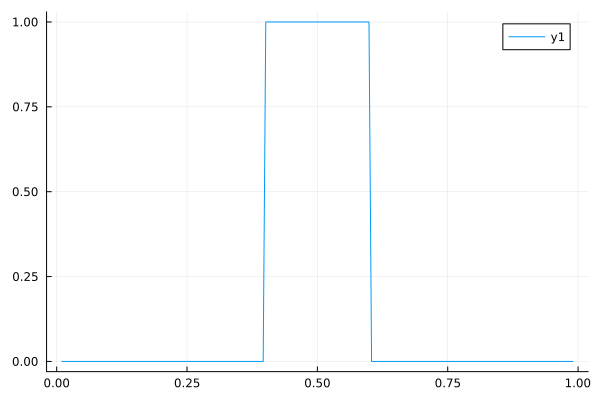

In [5]:
# initial condition
b = zeros(n)
b[80:120] = ones(41)
plot(range(0.01, 0.99, length=n), b)

In the exact (weak) solution, the square-wave moves to the right with velocity $v=1$, i.e., $u(x,t)=u(0,x-vt)$ (at least, until it hits the boundary). What do you observe in the numerical solution?

Try out the second gaussian initial condition too!

┌ Info: Saved animation to c:\Users\phros\Github\18335\psets\tmp.gif
└ @ Plots C:\Users\phros\.julia\packages\Plots\M4dfL\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\phros\\Github\\18335\\psets\\tmp.gif")
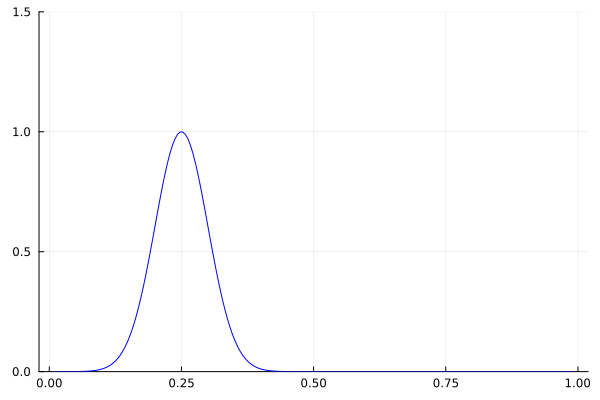

In [10]:
# initial condition 1 (square-wave)
#b = zeros(n)
#b[80:120] = ones(41)

# initial condition 2 (gaussian)
b = zeros(n)
x = range(0.01, 0.99, length=n)
b = exp.(-200*(x.-0.25).^2)

# time stepping gif
anim = Animation()
m = 200                         # number of steps in time 
for k ∈ 1:m                     # animate solution
    plot(range(0.01, 0.99, length=n), b, linecolor = :blue, legend = false)
    ylims!(0.0,1.5)
    b = advec_step(L,D,U,b)
    frame(anim)
end
gif(anim)

    

For a deeper understanding of the movie, one needs to go beyond linear algebra and understand the approximation properties of finite-difference schemes for partial differential equations like the advection equation.

# Problem 3: Regularized least-squares solutions

## Part (a)

We can calculate directly that the least-squares objective functions are equivalent because the sum of squared components of a partitioned vector $(x_1,\,x_2)^T$ satisfies $\|(x_1,\, x_2)^T\|_2^2=\|x_1\|_2^2+\|x_2\|_2^2$:

$$
\left\|\begin{pmatrix}A \\ \sqrt{\lambda}I \end{pmatrix}x - \begin{pmatrix}b \\ 0 \end{pmatrix}\right\|_2^2 = \left\|\begin{pmatrix}Ax-b \\ \sqrt{\lambda}x \end{pmatrix}\right\|_2^2 = \|Ax-b\|_2^2 + \sqrt{\lambda}\|x\|_2^2.
$$

## Part (b)

If we denote $\tilde A_\lambda = (A,\,\, \sqrt{\lambda}I)^T$ and $\tilde b = (b,\,\, 0)^T$, then the matrix $\tilde A_\lambda^T\tilde A_\lambda$ on the left-hand side of the normal equations for the regularized problem is
$$
\tilde A_\lambda^T\tilde A_\lambda
=
\begin{pmatrix}A^T & \sqrt{\lambda}I \end{pmatrix}
\begin{pmatrix}A \\ \sqrt{\lambda}I \end{pmatrix}
=
A^TA + \lambda I,
$$
while the right-hand side $\tilde A_\lambda^T\tilde b$ of the normal equations is
$$
\tilde A_\lambda^T\tilde b = \begin{pmatrix}A^T & \sqrt{\lambda}I \end{pmatrix}\begin{pmatrix}b \\ 0 \end{pmatrix} = A^Tb.
$$
Therefore, the normal equations for the regularized problem are $(A^TA+\lambda I)x_*=A^Tb$. Plugging in the SVD of $A$ yields $((U\Sigma V^*)^*(U\Sigma V^*) + \lambda I)x_* = (U\Sigma V^*)^*b$ and after simplification, we have
$$
(V\Sigma^*\Sigma V^* + \lambda I)x_* = V\Sigma^* U^*b, \qquad \implies \qquad V(\Sigma^*\Sigma + \lambda I)V^*x_* = V\Sigma^*U^*b.
$$
Inverting the coefficient matrix on the left-hand side of the right equation gives us our result: $x_* = V(\Sigma^*\Sigma + \lambda I)^{-1}\Sigma^*U^*b$.

## Part (c)

Note that the regularized least-squares problem _always_ has a unique solution because the augmented $(m+n)\times n$ matrix has full column rank due to the scaled identity in the lower $n\times n$ submatrix. From part (b), we can see that the $x_*$ tends to a solution of the usual least-suqares problem as $\lambda\rightarrow 0$ when $\Sigma^*\Sigma$ is invertivble, which is when $A$ itself has full column rank. In other words, when the usual least-squares problem has a unique solution, the regularized least-squares problem converges to it as the regularization parameter $\lambda$ is decreased to $0$.

## Part (d)

Implement a structure-exploiting Givens-based QR solver for the least-squares problem $$x_* = {\rm argmin}_x\left\|\begin{pmatrix}A \\ \\ \sqrt{\lambda}I \end{pmatrix}x - \begin{pmatrix}b \\ \\ 0 \end{pmatrix}\right\|_2^2.$$

This problem is hard if you are hoping to improve the flop count with a structure exploiting method: it is basically impossible to avoid fill-in in the lower $n\times n$ submatrix during triangularization. Although the lower $n\times n$ submatrix is diagonal at the beginning and is transformed into $n$ zero rows after triangularization, _every entry in the upper triangle_ of this bottom $n\times n$ submatrix will become nonzero during some intermediate step. Here is an illustration.

In [63]:
m = 12
n = 5                               # problem dimensions
A = randn(m,n)                      # random A for illustration
λ = 0.1                             # regularization parameter
D = diagm(0 => sqrt(λ)*ones(n))     # diagonal part from regularization
b = randn(m,1)                      # right-hand side for Least-Squares

# first triangularize A by Q'*A = R, and do the same orthogonal transformations to b, i.e., Q'*b
F = qr(A)
Qb = F.Q'*b

# we're left with the following structured system to triangularize (note the zero padding - F.R is the thin N×N QR factor - to make sure M has the same dimensions as the regularized (N+M) × N problem).
M = [F.R; zeros(m-n,n); D]

17×5 Matrix{Float64}:
 3.85094    1.8307    1.00003   -0.0122975   1.42019
 0.0       -3.50233   0.336004   0.211347    0.58646
 0.0        0.0       3.84088    0.913896   -0.37615
 0.0        0.0       0.0       -2.05091     0.199952
 0.0        0.0       0.0        0.0         2.57588
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.316228   0.0       0.0        0.0         0.0
 0.0        0.316228  0.0        0.0         0.0
 0.0        0.0       0.316228   0.0         0.0
 0.0        0.0       0.0        0.316228    0.0
 0.0        0.0       0.0        0.0         0.316228

We now have a matrix that is upper triangular except for $n$ entries along the diagonal of the _bottom_ $n\times n$ submatrix. 

<br />

We can use the $(n,n)$ entry - the lower right entry in the upper triangular part - to zero out the $(m+n,n)$ entry in the bottom submatrix. 

In [64]:
G = givens(M,n,m+n,n)
M = G[1]*M

17×5 Matrix{Float64}:
 3.85094    1.8307    1.00003   -0.0122975   1.42019
 0.0       -3.50233   0.336004   0.211347    0.58646
 0.0        0.0       3.84088    0.913896   -0.37615
 0.0        0.0       0.0       -2.05091     0.199952
 0.0        0.0       0.0        0.0         2.59522
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.316228   0.0       0.0        0.0         0.0
 0.0        0.316228  0.0        0.0         0.0
 0.0        0.0       0.316228   0.0         0.0
 0.0        0.0       0.0        0.316228    0.0
 0.0        0.0       0.0        0.0        -5.55112e-17

2.5952215394201508

So far so good! We have zeroed out one of the entries and introduced no new nonzeros. 

<br />

Let's try to go further: we'll use the second diagonal entry (the $(n-1,n-1)$ entry) to zero out the last subdiagonal entry (the $(m+n-1,n-1)$ entry) in the second-to-last column.

In [65]:
G = givens(M,n-1,m+n-1,n-1)
M = G[1]*M

17×5 Matrix{Float64}:
 3.85094    1.8307    1.00003   -0.0122975   1.42019
 0.0       -3.50233   0.336004   0.211347    0.58646
 0.0        0.0       3.84088    0.913896   -0.37615
 0.0        0.0       0.0       -2.07515     0.197616
 0.0        0.0       0.0        0.0         2.59522
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.0        0.0       0.0        0.0         0.0
 0.316228   0.0       0.0        0.0         0.0
 0.0        0.316228  0.0        0.0         0.0
 0.0        0.0       0.316228   0.0         0.0
 0.0        0.0       0.0        0.0         0.0304702
 0.0        0.0       0.0        0.0        -5.55112e-17

-2.0751498876892387

This time, a new nonzero entry appeared in the $(m+n-1,n)$ place, because of the nonzero $(n-1,n)$ entry! We can eliminate this new nonzero using the $(n,n)$ entry though.

In [58]:
G = givens(M,n,m+n-1,n)
M = G[1]*M

17×5 Matrix{Float64}:
 -2.72483   -0.652295   0.137634  1.69485  -1.6163
  0.0        1.99702   -0.462291  1.41197  -0.12319
  0.0        0.0       -1.62827   0.86607  -0.525973
  0.0        0.0        0.0       2.01765  -0.976276
  0.0        0.0        0.0       0.0       2.98912
  0.0        0.0        0.0       0.0       0.0
  0.0        0.0        0.0       0.0       0.0
  0.0        0.0        0.0       0.0       0.0
  0.0        0.0        0.0       0.0       0.0
  0.0        0.0        0.0       0.0       0.0
  0.0        0.0        0.0       0.0       0.0
  0.0        0.0        0.0       0.0       0.0
  0.316228   0.0        0.0       0.0       0.0
  0.0        0.316228   0.0       0.0       0.0
  0.0        0.0        0.316228  0.0       0.0
  0.0        0.0        0.0       0.0       0.0
  0.0        0.0        0.0       0.0       0.0

We are making progress! But the general pattern is starting to show. When we zero out the next subdiagonal entry in the third column, we will introduce two new nonzeros to the right, and we will need to eliminate these in turn using the second to last and last rows of the upper triangular part. Here's the new nonzeros.

In [59]:
G = givens(M,n-2,m+n-2,n-2)
M = G[1]*M

17×5 Matrix{Float64}:
 -2.72483   -0.652295   0.137634  1.69485   -1.6163
  0.0        1.99702   -0.462291  1.41197   -0.12319
  0.0        0.0       -1.65869   0.850185  -0.516325
  0.0        0.0        0.0       2.01765   -0.976276
  0.0        0.0        0.0       0.0        2.98912
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.316228   0.0        0.0       0.0        0.0
  0.0        0.316228   0.0       0.0        0.0
  0.0        0.0        0.0       0.165116  -0.100276
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0

We eliminate the $(n-2,n-1)$ entry...

In [60]:
G = givens(M,n-1,m+n-2,n-1)
M = G[1]*M

17×5 Matrix{Float64}:
 -2.72483   -0.652295   0.137634  1.69485   -1.6163
  0.0        1.99702   -0.462291  1.41197   -0.12319
  0.0        0.0       -1.65869   0.850185  -0.516325
  0.0        0.0        0.0       2.0244    -0.981202
  0.0        0.0        0.0       0.0        2.98912
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.316228   0.0        0.0       0.0        0.0
  0.0        0.316228   0.0       0.0        0.0
  0.0        0.0        0.0       0.0       -0.0203142
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0

And then the $(n-2,n)$ entry...

In [61]:
G = givens(M,n,m+n-2,n)
M = G[1]*M

17×5 Matrix{Float64}:
 -2.72483   -0.652295   0.137634  1.69485   -1.6163
  0.0        1.99702   -0.462291  1.41197   -0.12319
  0.0        0.0       -1.65869   0.850185  -0.516325
  0.0        0.0        0.0       2.0244    -0.981202
  0.0        0.0        0.0       0.0        2.98919
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0
  0.316228   0.0        0.0       0.0        0.0
  0.0        0.316228   0.0       0.0        0.0
  0.0        0.0        0.0       0.0        3.46945e-18
  0.0        0.0        0.0       0.0        0.0
  0.0        0.0        0.0       0.0        0.0

Wrapping up the triangularization by finishing off the first two columns looks like this.

In [62]:
# second column
G = givens(M,n-3,m+n-3,n-3)
M = G[1]*M

# sweep to eliminate fill in
for j in 2:-1:0
    G = givens(M,n-j,m+n-3,n-j)
    M = G[1]*M
end

# first column
G = givens(M,n-4,m+n-4,n-4)
M = G[1]*M

# sweep to eliminate fill in
for j in 3:-1:0
    G = givens(M,n-j,m+n-4,n-j)
    M = G[1]*M
end
display(M)

17×5 Matrix{Float64}:
 -2.74312  -0.647946   0.136716      1.68355      -1.60553
  0.0       2.0233    -0.456876      1.38637      -0.114665
  0.0       0.0       -1.66026       0.859161     -0.516803
  0.0       0.0        1.21826e-18   2.0476       -0.992713
  0.0       0.0        4.33095e-19   6.62331e-19   2.99145
  0.0       0.0        0.0           0.0           0.0
  0.0       0.0        0.0           0.0           0.0
  0.0       0.0        0.0           0.0           0.0
  0.0       0.0        0.0           0.0           0.0
  0.0       0.0        0.0           0.0           0.0
  0.0       0.0        0.0           0.0           0.0
  0.0       0.0        0.0           0.0           0.0
  0.0       0.0       -3.55932e-19  -2.77477e-17   0.0
  0.0       0.0       -1.38145e-17   0.0           0.0
  0.0       0.0        0.0           0.0           3.46945e-18
  0.0       0.0        0.0           0.0           0.0
  0.0       0.0        0.0           0.0           0.0

Our matrix is now (numerically) upper triangular! But we had to work hard to get there - much harder than the $\mathcal{O}(n)$ "extra" operations we might have hoped for to take care of the diagonal $n\times n$ submatrix from regularization.

<br />

To introduce a new zero on the diagonal $(k,k)$ entry of the bottom $n\times n$ submatrix, we had to mix two rows of length $n-k$ using a Givens rotation, which introduced $n-k-1$ new nonzero entries. To eliminate _each_ of these, we had to mix two more rows using another Givens rotations! Overall, the number of flops to eliminate the entire bottom $n\times n$ submatrix is approximately

$$
\sum_{k=1}^n \sum_{j=1}^k 3j = \frac{3n(n+1)(n+2)}{6}=\mathcal{O}(n^3).
$$


So the full cost is the cost of the QR factorization of the $n\times m$ matrix $A$ plus an $\mathcal{O}(n^3)$ term. For comparison, the cost of Householder triangularization of the full $(m+n)\times n$ matrix is $2(m+n)n^2 - n^3/3=(2mn^2 - n^3/3) + 2n^3$, which is also the cost of triangularizing $A$ plus an $\mathcal{O}(n^3)$ term.

<br />

Here is a toy code illustrating the Givens-based approach outlined above.

In [81]:
function qrsolve(A, b, λ)
    ## YOUR SOLUTION HERE

    # matrix dimensions
    R = copy(A)
    m = size(R,1)
    n = size(R,2)

    rhs = copy(b)

    # first triangularize A by Q'*A = R, and do the same orthogonal transformations to b, i.e., rhs = Q'*b
    F = qr(A)
    rhs = F.Q'*rhs

    # we're left with the following structured system to triangularize (note the zero padding - F.R is the thin N×N QR factor - to make sure M has the same dimensions as the regularized (N+M) × N problem).
    M = [F.R; zeros(m-n,n); diagm(0 => sqrt(λ)*ones(n))]
    rhs = [rhs; zeros(n)]

    # zero out subdiagonal entry in last column
    G = givens(M,n,m+n,n)
    M = G[1]*M
    rhs = G[1]*rhs                                  # update right-hand side

    # now sweep through introducing zeros and eliminating fill-in
    for k in n-1:-1:1
        G = givens(M,k,m+k,k)       # zero out (m+k,k) entry with Givens
        M = G[1]*M
        rhs = G[1]*rhs              # update right-hand side
        for j in k+1:n              # sweep through eliminating fill-in
            G = givens(M,j,m+k,j)
            M = G[1]*M
            rhs = G[1]*rhs          # udpate right-hand side
        end
    end

    # solve triangular least-squares system
    xmin = M \ rhs
    

    return xmin
end

# toy problem parameters
m = 12
n = 5                               # problem dimensions
A = randn(m,n)                      # random A for illustration
λ = 0.1                             # regularization parameter
D = diagm(0 => sqrt(λ)*ones(n))     # diagonal part from regularization
b = randn(m,1)                      # right-hand side for Least-Squares

# compare qrsolve with solution from standard QR solver
xmin = qrsolve(A,b,λ)
xtrue = [A; diagm(0 => sqrt(λ)*ones(n))] \ [b; zeros(n)]
norm(xmin-xtrue)

2.7052788744732945e-16

## Part (e) - NOT FOR CREDIT

The rest of this notebook explores solutions to the regularized least-squares problem. Experiment if you are curious! There are no tasks "for credit" beyond this point.

Consider the following $100\times 50$ ill-conditioned least-squares problem $Ax=b$, where the last $20$ singular values of $A$ decay rapidly to about $10^{-6}$.

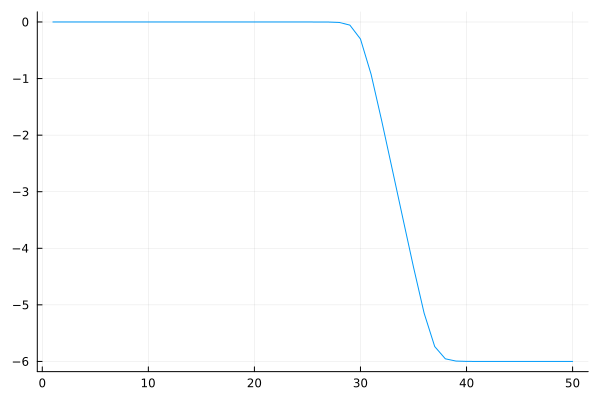

In [145]:
# singular values with decay profile
x = 1:50
v = 1e-6 .+ (1 ./ (1 .+ exp.(2*(x .- 30))))
plot(x,log10.(v), legend = false)

In [146]:
# matrix constructed from SVD
U = qr(rand(100,100)).Q
V = qr(randn(50,50)).Q
Σ = [diagm(v); zeros(50,50)]
A = U * Σ * V'
cond(A)

1.0000010000347686e6

Given a random right-hand side $b$, plot the terms $\|Ax_*-b\|$ and $\|x_*\|$ as $\lambda\rightarrow 0$.

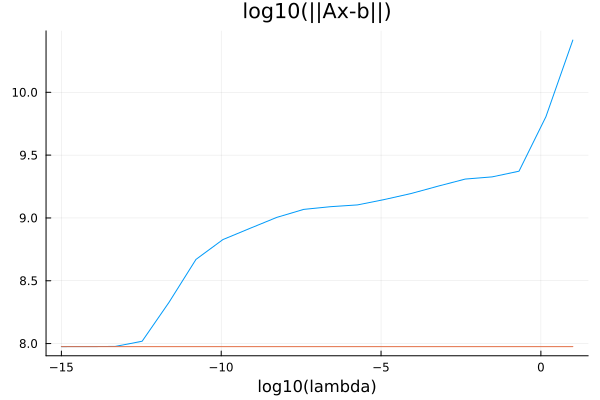

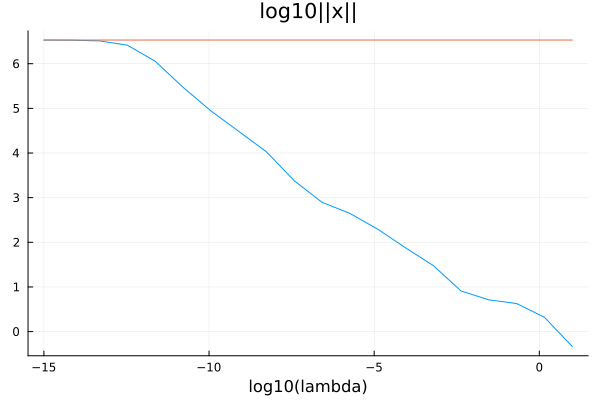

In [147]:
# random right-hand side
b = randn(100)

# "exact" least-squares solution (warning: ill-conditioned)
x0 = A \ b
res = norm(A*x0 - b)

# range of \lambda
l = 20
p = LinRange(-1,15,l)
λ = 10 .^ (-p)

# iterate over \lambda
errx = zeros(l)
resAx = zeros(l)
normx = zeros(l)
for j ∈ 1:l
    x = V * ( (Σ'*Σ+λ[j]*I) \ (Σ' * U' *b) )
    resAx[j] = norm(A*x-b)
    normx[j] = norm(x)
end

p1 = plot(log10.(λ), resAx, legend = false, title = "log10(||Ax-b||)", xlabel = "log10(lambda)")
plot!(log10.(λ), res * ones(length(λ)), legend = false)
p2 = plot(log10.(λ), log10.(normx), legend = false, title = "log10||x||", xlabel = "log10(lambda)")
plot!(log10.(λ), log10(norm(x0)) * ones(length(λ)), legend = false)
display(p1)
display(p2)


Now, try adjusting the singular value profile of $A$ (for example, lower the plateau at $10^{-6}$ to $10^{-9}$) and see what changes!